In [18]:
# %load Baseline_Model.py
import torch
from torch.autograd import Variable
import torch.nn.functional as F

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')

import numpy as np

hdf5_filename = "assignment1_data-1.hdf5"


# Read files
with h5py.File(hdf5_filename, "r") as f:
    dset = f["mydataset"]
    label = dset[:,-1] # N by 1, where N is the number of samples
    X = dset[:,0:-1] # N by F, where F is the number of features

X = torch.Tensor(X)
label = torch.Tensor(label)
torch.manual_seed(42)    # reproducible

scaler = StandardScaler()
X = scaler.fit_transform(X)
X = preprocessing.scale(X)
#print(X[20000:21000,:])

class SplittedDataset:

    def __init__(self, X, Y, train_frac, val_frac):
        X = torch.Tensor(X)
        Y = torch.Tensor(Y)
        self.X = X
        self.Y = Y
        self.train_frac = train_frac
        self.val_frac = val_frac
        self.test_frac = 1 - train_frac - val_frac
        # train/val/test split
        permutation = torch.randperm(len(X))
        train_size = int(len(X)*train_frac)
        val_size = int(len(X)*val_frac)
        train_indices = permutation[0 : train_size]
        val_indices = permutation[train_size : train_size + val_size]
        test_indices = permutation[train_size + val_size : ]
        self.X_train = X[train_indices]
        self.Y_train = Y[train_indices]
        self.X_val = X[val_indices]
        self.Y_val = Y[val_indices]
        self.X_test = X[test_indices]
        self.Y_test = Y[test_indices]
    
    def __len__(self):
        return len(self.X)
    
    def __str__(self):
        return "splitted dataset with {} samples and {} training ".format(len(self.X),self.train_frac)
    
dataset = SplittedDataset(X, label, 0.7, 0.1)
print(dataset.X_train.shape)
print(dataset.X_val.shape)

torch.Size([64878, 57])
torch.Size([9268, 57])


test loss: 14.317673683166504
test loss: 14.280570030212402
test loss: 14.242231369018555
test loss: 14.201981544494629
test loss: 14.159683227539062
test loss: 14.115561485290527
test loss: 14.069161415100098
test loss: 14.02122974395752
test loss: 13.972137451171875
test loss: 13.922435760498047
test loss: 13.872550010681152
test loss: 13.82320499420166
test loss: 13.774060249328613
test loss: 13.725329399108887
test loss: 13.676363945007324
test loss: 13.627923011779785
test loss: 13.580282211303711
test loss: 13.531391143798828
test loss: 13.481278419494629
test loss: 13.43209171295166
test loss: 13.381439208984375
test loss: 13.329648971557617
test loss: 13.278097152709961
test loss: 13.22568130493164
test loss: 13.171465873718262
test loss: 13.11751937866211
test loss: 13.063522338867188
test loss: 13.010645866394043
test loss: 12.958373069763184
test loss: 12.906463623046875
test loss: 12.855277061462402
test loss: 12.804490089416504
test loss: 12.755463600158691
test loss: 12.7

test loss: 4.218075752258301
test loss: 4.215677261352539
test loss: 4.215053558349609
test loss: 4.216211795806885
test loss: 4.218155860900879
test loss: 4.219898700714111
test loss: 4.2176289558410645
test loss: 4.212427139282227
test loss: 4.213863849639893
test loss: 4.216771125793457
test loss: 4.219471454620361
test loss: 4.222376823425293
test loss: 4.2192158699035645
test loss: 4.216601848602295
test loss: 4.21302604675293
test loss: 4.213308334350586
test loss: 4.213265419006348
test loss: 4.212854385375977
test loss: 4.215797424316406
test loss: 4.218896389007568
test loss: 4.219493865966797
test loss: 4.219090461730957
test loss: 4.219760894775391
test loss: 4.218412399291992
test loss: 4.219350814819336
test loss: 4.214094638824463
test loss: 4.2107930183410645
test loss: 4.211376667022705
test loss: 4.2143120765686035
test loss: 4.213703632354736
test loss: 4.217660903930664
test loss: 4.218847751617432
test loss: 4.21708345413208
test loss: 4.2159881591796875
test loss: 

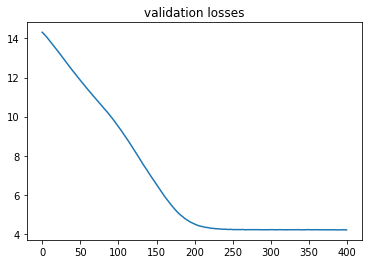

In [21]:
batch_size = 20000
n_epochs = 400

class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden1, n_hidden2, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)   # hidden layer
        self.bn1 = torch.nn.BatchNorm1d(n_hidden1)
        #self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2)
        self.predict = torch.nn.Linear(n_hidden1, n_output)   # output layer

    def forward(self, x):
        x = F.tanh(self.hidden1(x))      # activation function for hidden layer
        x = self.bn1(x)
        #x = F.relu(self.hidden2(x))      # activation function for hidden layer
        x = self.predict(x)              # linear output
        return x
    
    def train(self, X, label, n_epochs, batch_size, 
              optimizer,
              loss_func = torch.nn.MSELoss(),
              verbose = False,
              val = False, X_val = None, Y_val = None):
        
        def vprint(s):
            if verbose: 
                print(s)
                
        train_losses = []
        val_losses = []
        # train the network
        for t in range(n_epochs):
            vprint("epoch {}".format(t))
            permutation = torch.randperm(len(X))
    
            for batch_index in range(0,len(X),batch_size):
                indices = permutation[batch_index: batch_index + batch_size]

                batch_X, batch_label = X[indices], label[indices]

                prediction = self.forward(batch_X)     # input x and predict based on x
                loss = loss_func(prediction.squeeze(), batch_label)     # must be (1. nn output, 2. target)
                loss = torch.sqrt(loss)
                train_losses.append(loss)
                
                vprint(batch_label[:10])
                vprint("===============")
                vprint(prediction[:10])
                vprint("current loss: {:10.2f}".format(loss))
                vprint("***********************")

                optimizer.zero_grad()   # clear gradients for next train
                loss.backward()         # backpropagation, compute gradients
                optimizer.step()        # apply gradients
            if val:
                val_loss, _ = self.test(X_val, Y_val, loss_func)
                val_losses.append(val_loss)
        print("training done!")
#         plt.plot(train_losses)
#         plt.title('train losses')
        plt.figure()
        plt.plot(val_losses)
        plt.title('validation losses')
        return val_losses
    
    def test(self, X, label, loss_func = torch.nn.MSELoss()):
        prediction = self.forward(X)
        loss = loss_func(prediction.squeeze(), label)
        loss = torch.sqrt(loss)
        print("test loss: {}".format(loss))
        return loss, prediction
    
    # visualize correlation between truth and prediction
    def visualize_corr(self, pred, true):
        true = true.detach().numpy()
        pred = pred.detach().numpy()
        plt.figure()
        plt.scatter(true,pred,s=0.1)
        plt.xlim(0, 100)
    
    # visualize true and predicted distribution
    def visualize_dist(self, pred, true):
        plt.figure()
        x = label[label>0]
        x = x[x<60]
        his = plt.hist(x,bins=100)
        plt.hist(pred,true)

# set constants for network
net = Net(n_feature=X.shape[1], n_hidden1=10, n_hidden2=6, n_output=1)     # define the network
#optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
optimizer = torch.optim.Adam(net.parameters())
val_losses = net.train(dataset.X_train, dataset.Y_train, n_epochs, batch_size, optimizer,verbose=False, val = True,
           X_val = dataset.X_val, Y_val = dataset.Y_val)
# pred = net.test(dataset.X_test, dataset.Y_test)
# print(pred.shape)

Text(0, 0.5, 'Root Mean Square Loss (in minutes)')

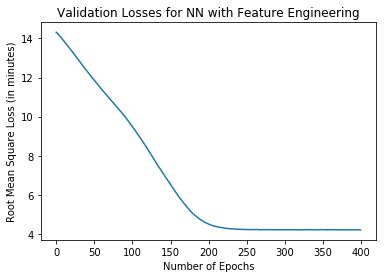

In [23]:
plt.plot(val_losses)
plt.title("Validation Losses for NN with Feature Engineering")
plt.xlabel("Number of Epochs")
plt.ylabel("Root Mean Square Loss (in minutes)")

Text(0.5, 1.0, 'Histogram of Predicted Travel Time Distribution')

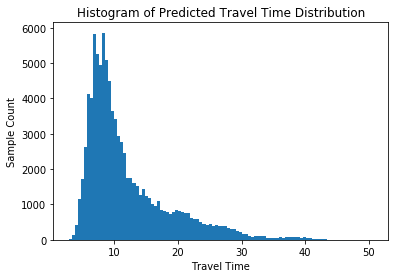

In [24]:
pred = net(torch.Tensor(X))
pred = pred.detach().numpy()
x = pred[pred>0]
x = x[x<60]
his = plt.hist(x,bins=100)
plt.xlabel("Travel Time")
plt.ylabel("Sample Count")
plt.title("Histogram of Predicted Travel Time Distribution")